In [70]:
import pandas as pd
import datetime
from datetime import datetime as dt

def create_k_data(ticker='BTC'):
    df = pd.read_csv(f'../{ticker}-USD.csv')
    df = df.reset_index()
    df = df.rename(columns={'index': 'key'})
    df.columns = df.columns.str.lower()
    K_DEFAULT_DT_FMT = "%Y-%m-%d"
    def week_of_date(date_str, fmt=K_DEFAULT_DT_FMT):
        """
        输入'2016-01-01' 转换为星期几，返回int 0-6分别代表周一到周日
        :param date_str: 式时间日期str对象
        :param fmt: 如date_str不是%Y-%m-%d形式，对应的格式str对象
        :param fix: 是否修复日期不规范的写法，eg. 2016-1-1 fix 2016-01-01
        :return: 返回int 0-6分别代表周一到周日
        """
        return dt.strptime(date_str, fmt).weekday()
        
    df['date_week'] = df['date'].apply(lambda x: dt.strptime(str(x), '%Y-%m-%d').weekday())
    df['date'] = df['date'].apply(lambda x: dt.strptime(str(x), '%Y-%m-%d'))
    df['p_change'] = np.log(df.close/df.close.shift(1))*100
    
    df = df.set_index('date')
    return df

btc_df = create_k_data('BTC')
btc_df.head()
# standarlize data, index as close_date, all lower case

,key,open,high,low,close,adj close,volume,date_week,p_change
date,,,,,,,,,
2020-01-01,0,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,2,NaN
2020-01-02,1,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,3,-3.027293
2020-01-03,2,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,4,5.017175
2020-01-04,3,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275,5,0.891501
2020-01-05,4,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095,6,0.008914


### 1. Matplot basic 

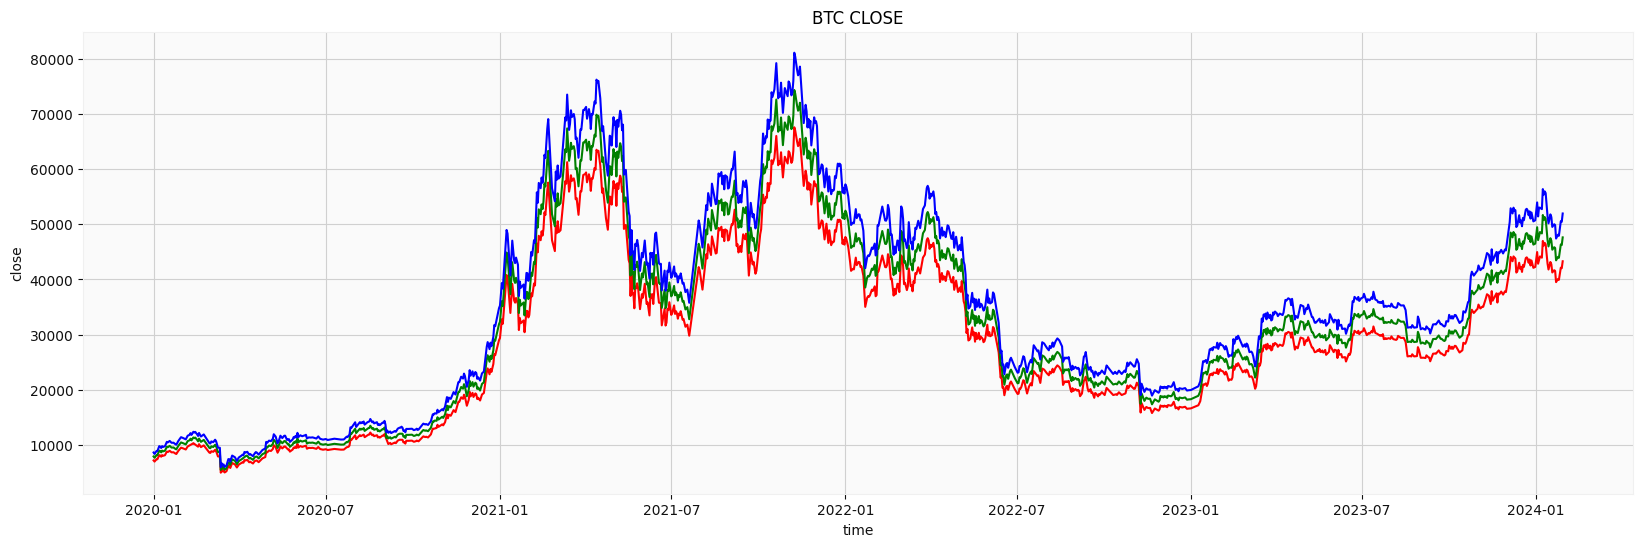

In [79]:
import matplotlib.pyplot as plt
def plot_demo(df, axs=None, just_series=False, figsize=(20, 6)):
    """
    draw close px 
    :param axs: axs为子画布，稍后会详细讲解
    :param just_series: 是否只绘制一条收盘曲线使用series，后面会用到
    :return: 
    """
    # 如果参数传入子画布则使用子画布绘制，下一节会使用
    if axs is None:
        plt.figure(figsize=figsize)  # 在这里设置图形的大小
        drawer = plt
    else:
        drawer = axs  # 假设外部传入的axs已经有了figsize的设定
    # Series对象tsla_df.close，红色
    drawer.plot(df.close, c='r')
    if not just_series:
        # 为曲线不重叠，y变量加了10个单位tsla_df.close.values + 10
        # numpy对象tsla_df.close.index ＋ tsla_df.close.values，绿色
        drawer.plot(df.close.index, df.close.values*1.1, c='g')
        # 为曲线不重叠，y变量加了20个单位
        # list对象，numpy.tolist()将numpy对象转换为list对象，蓝色
        drawer.plot(df.close.index.tolist(), (df.close.values*1.2).tolist(), c='b')

    plt.xlabel('time')
    plt.ylabel('close')
    plt.title('BTC CLOSE')
    plt.grid(True)

plot_demo(btc_df)

### matplotlib子画布及loc的使用

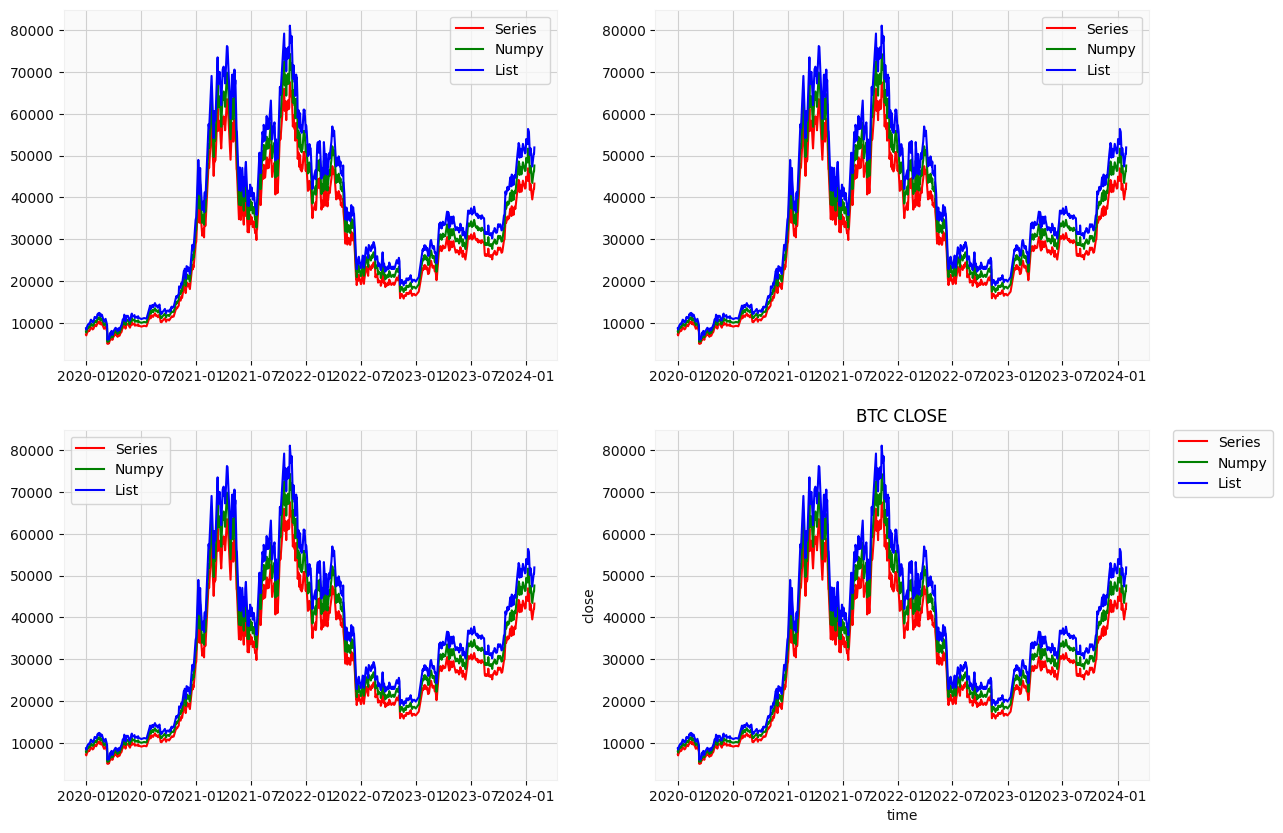

In [80]:
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
# 画布0，loc：0 plot_demo中传入画布，则使用传入的画布绘制
drawer = axs[0][0]
plot_demo(btc_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], loc=0)
# 画布1，loc：1 
drawer = axs[0][1]
plot_demo(btc_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], loc=1)
# 画布2，loc：2 
drawer = axs[1][0]
plot_demo(btc_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], loc=2)
# 画布3，loc：2， 设置bbox_to_anchor，在画布外的相对位置绘制
drawer = axs[1][1]
plot_demo(btc_df, drawer)
drawer.legend(['Series', 'Numpy', 'List'], bbox_to_anchor=(1.05, 1),
              loc=2,
              borderaxespad=0.);

# loc 一般无特殊要求，使用loc='best'指定

### 3. k线图的绘制

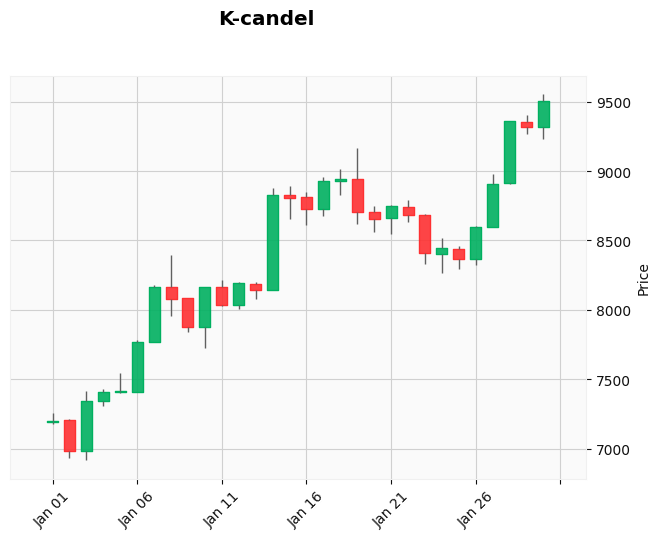

In [81]:
import mplfinance as mpf

__colorup__ = "red"
__colordown__ = "green"
# 为了示例清晰，只拿出前30天的交易数据绘制蜡烛图，
btc_part_df = btc_df[:30]
mpf.plot(btc_part_df, type='candle', style='yahoo', title="K-candel", ylabel="Price")
#btc_part_df

### 如何计算风险？

In [49]:
import numpy as np
def rolling_std(list, window):
    return pd.Series(list).std() * np.sqrt(window)

data = {'value': [2,4,16,20]}
df = pd.DataFrame(data)

rolling_std = df['value'].rolling(window=3).std()*np.sqrt(3)
print(rolling_std)
#rolling_std([2,4,16],3)

0          NaN
1          NaN
2    13.114877
3    14.422205
Name: value, dtype: float64


### calculate return: return rate = np.log(df['close']/ df['close'].shift(1))

In [50]:
rolling_mean = df['value'].rolling(window=3).mean()
rolling_mean

0          NaN
1          NaN
2     7.333333
3    13.333333
Name: value, dtype: float64

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

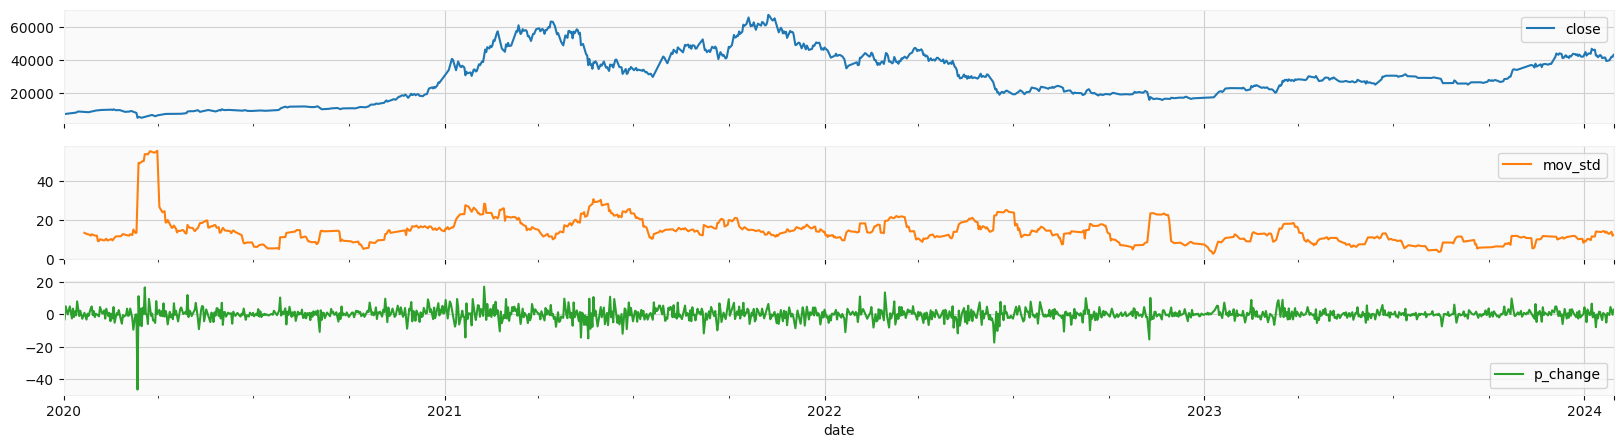

In [51]:
df = btc_df.copy()
df['mov_std'] = df['p_change'].rolling(window=20).std()*np.sqrt(20)
df[['close','mov_std','p_change']].plot(figsize=(20,5), subplots=True, grid=True)

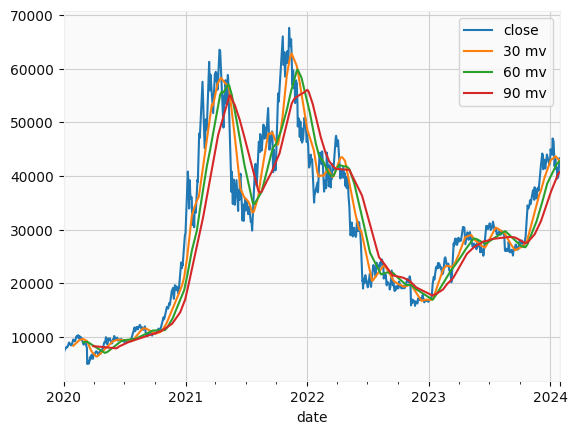

In [82]:
# draw moving average
df.close.plot()
df['close'].rolling(window=30).mean().plot()
df['close'].rolling(window=60).mean().plot()
df['close'].rolling(window=90).mean().plot()
plt.legend(['close','30 mv','60 mv', '90 mv'], loc='best')

### Strategy 1, when the open price is lower than close price, it's likely next day it will increase. 

In [83]:
low_to_high_df = df.iloc[df[(df.close > df.open) & (df.key != df.shape[0] - 1)].key.values + 1]

# iloc获取所有低开高走的下一个交易日组成low_to_high_df，由于是下一个交易日
# 所以要对满足条件的交易日再次通过iloc获取，下一个交易日index用key.values + 1

# 通过where将下一个交易日的涨跌幅通过ceil，floor向上，向下取整
change_ceil_floor = np.where(low_to_high_df['p_change'] > 0,
                             np.ceil(
                                 low_to_high_df['p_change']),
                             np.floor(
                                 low_to_high_df['p_change']))

# 使用pd.Series包裹，方便之后绘制
change_ceil_floor = pd.Series(change_ceil_floor)

低开高收的下一个交易日所有下跌的跌幅取整和sum: -1060.0
低开高收的下一个交易日所有上涨的涨幅取整和sum: 1053.0


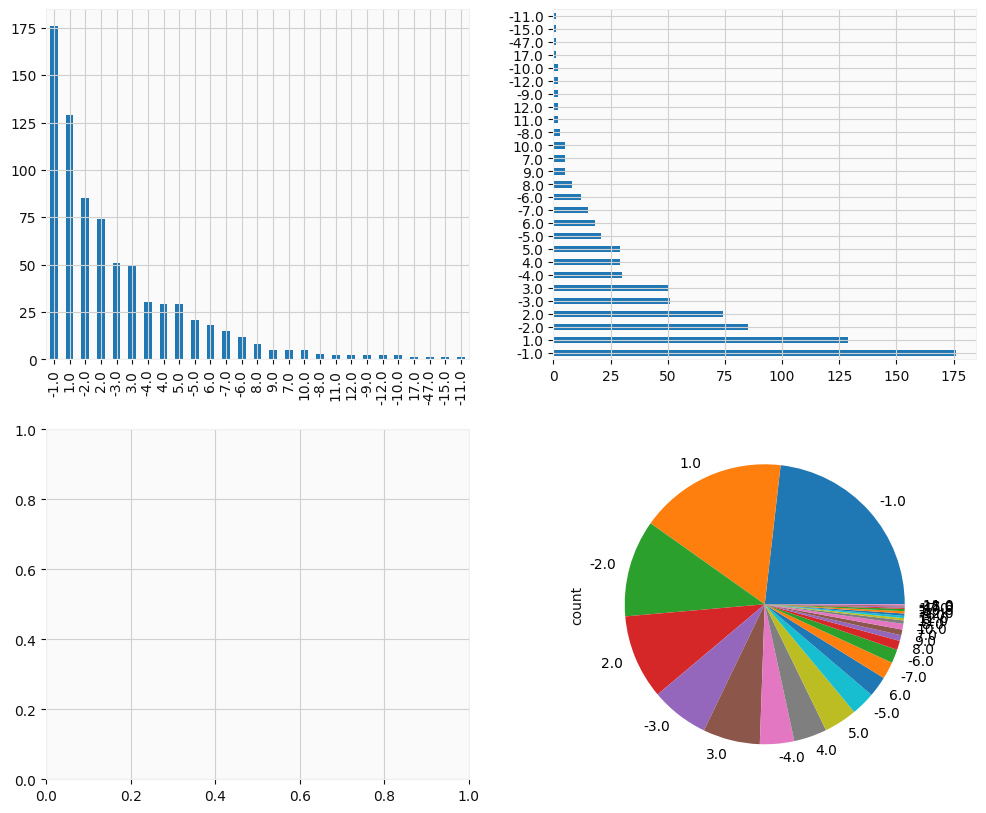

In [84]:
#import skipy
print('低开高收的下一个交易日所有下跌的跌幅取整和sum: ' + str(
change_ceil_floor[change_ceil_floor < 0].sum()))

print('低开高收的下一个交易日所有上涨的涨幅取整和sum: ' + str(
change_ceil_floor[change_ceil_floor > 0].sum()))

# 2 * 2: 四张子图
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
# 竖直柱状图，可以看到-1的柱子最高, 图5-7左上
change_ceil_floor.value_counts().plot(kind='bar', ax=axs[0][0])
# 水平柱状图，可以看到-1的柱子最长, 图5-7右上
change_ceil_floor.value_counts().plot(kind='barh', ax=axs[0][1])
# 概率密度图，可以看到向左偏移, 图5-7左下
#change_ceil_floor.value_counts().plot(kind='kde', ax=axs[1][0])
# 圆饼图，可以看到－1所占的比例最高, -2的比例也大于＋2，图5-7右下
change_ceil_floor.value_counts().plot(kind='pie', ax=axs[1][1]);

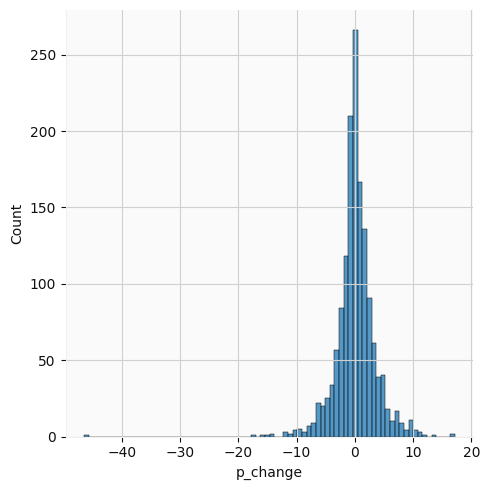

In [85]:
import seaborn as sns
sns.displot(df['p_change'], bins=80);

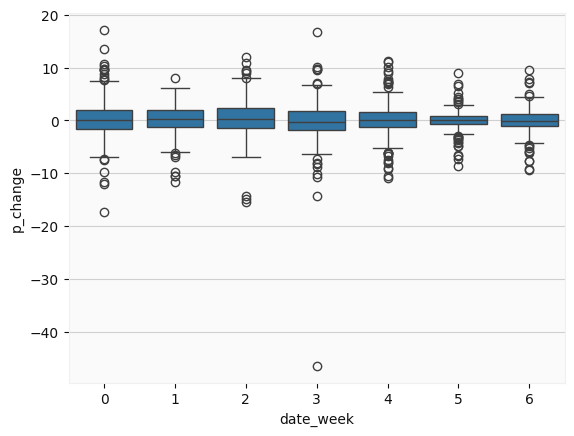

In [86]:
sns.boxplot(x='date_week', y='p_change', data=df);

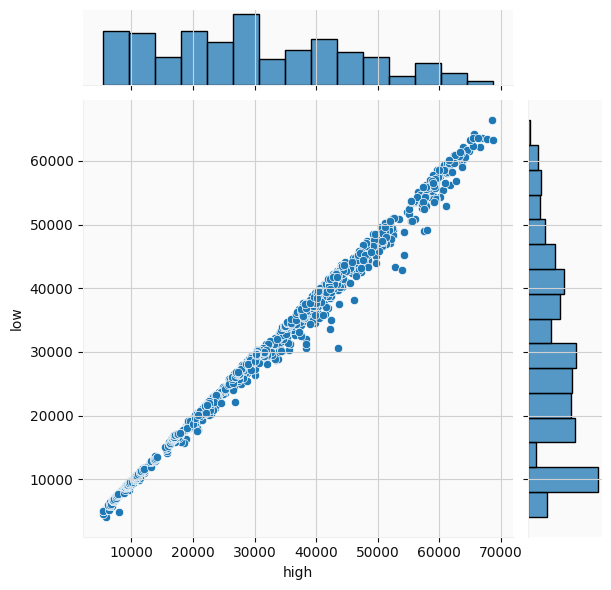

In [87]:
sns.jointplot(df, x="high", y="low");

In [88]:
change_df = pd.DataFrame({'btc': df.p_change})
# join usGOOG
change_df = change_df.join(pd.DataFrame({'eth': create_k_data('ETH').p_change}), how='outer')
change_df = change_df.join(pd.DataFrame({'gmt': create_k_data('GMT').p_change}), how='outer')
change_df = change_df.join(pd.DataFrame({'sol': create_k_data('SOL').p_change}), how='outer')

change_df = change_df.dropna()
# 表5-2所示
change_df.head()

,btc,eth,gmt,sol
date,,,,
2021-04-14,-0.621994,5.743396,23.546385,23.546385
2021-04-15,0.323225,3.391826,12.383593,12.383593
2021-04-16,-2.788662,-3.521615,-19.438312,-19.438312
2021-04-17,-1.454293,-3.645135,22.262919,22.262919
2021-04-18,-7.647243,-4.704373,-5.535175,-5.535175


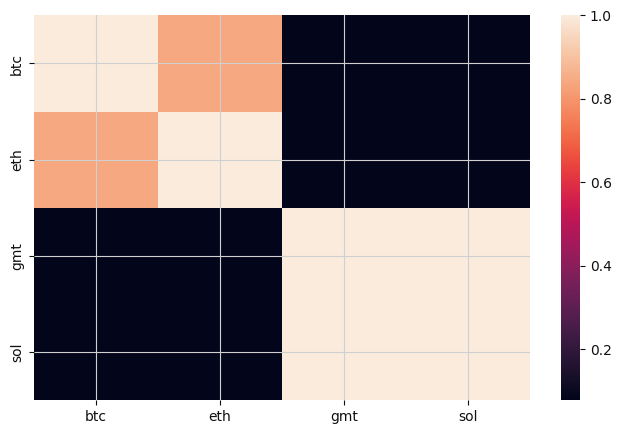

In [89]:
# 使用corr计算数据的相关性
corr = change_df.corr()
_, ax = plt.subplots(figsize=(8, 5))
# sns.heatmap热力图展示每组股票涨跌幅的相关性
sns.heatmap(corr, ax=ax);

### 5.5 实例1:可视化量化策略的交易区间，卖出原因

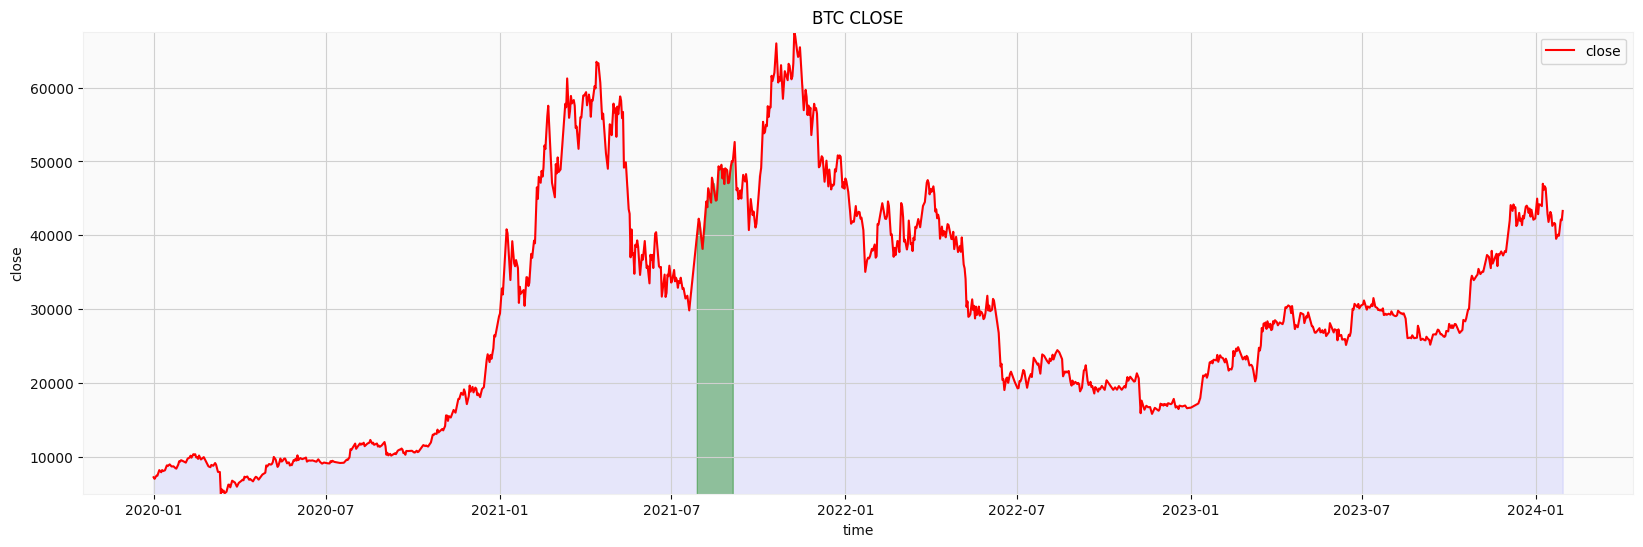

In [90]:
def plot_trade(df, buy_date, sell_date):
    # 找出2014-07-28对应时间序列中的index作为start
    start = df[df.index == buy_date].key.values[0]
    # 找出2014-09-05对应时间序列中的index作为end
    end = df[df.index == sell_date].key.values[0]
    
    # 使用5.1.1封装的绘制tsla收盘价格时间序列函数plot_demo
    # just_series＝True, 即只绘制一条曲线使用series数据
    plot_demo(df, just_series=True)

    # 将整个时间序列都填充一个底色blue，注意透明度alpha=0.08是为了
    # 之后标注其他区间透明度高于0.08就可以清楚显示
    plt.fill_between(df.index, 0, df['close'], color='blue', alpha=.08)

    # 标注股票持有周期绿色，使用start和end切片周期
    # 透明度alpha=0.38 > 0.08
    plt.fill_between(df.index[start:end], 0,
                     df['close'][start:end], color='green',
                     alpha=.38)
    
    # 设置y轴的显示范围，如果不设置ylim，将从0开始作为起点显示，效果不好
    plt.ylim(np.min(df['close']) - 5,
             np.max(df['close']) + 5)
    # 使用loc='best'
    plt.legend(['close'], loc='best')

# 标注交易区间2014-07-28到2014-09-05, 图5-12所示
start = datetime.datetime(2021,7,28)
end = datetime.datetime(2021,9,5)
plot_trade(btc_df, start, end)

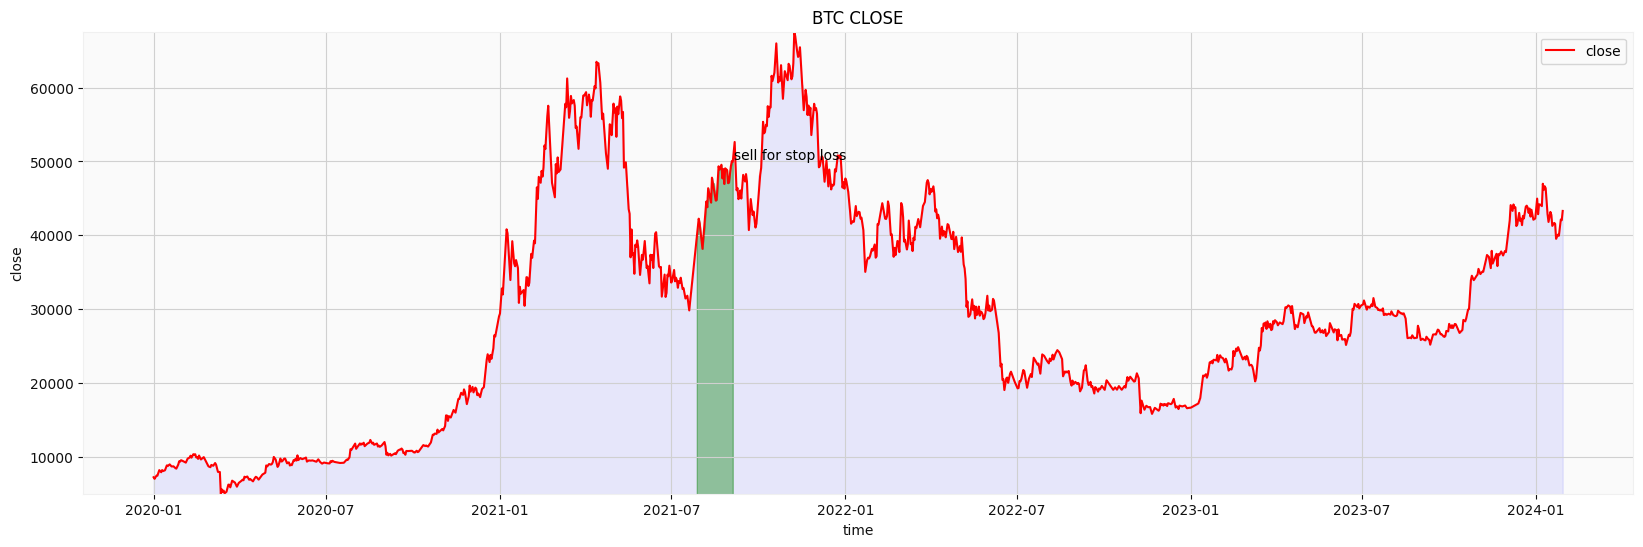

In [91]:
def plot_trade_with_annotate(df, buy_date, sell_date, annotate):
    """
    :param buy_date: 交易买入日期
    :param sell_date: 交易卖出日期
    :param annotate: 卖出原因
    :return: 
    """
    # 标注交易区间buy_date到sell_date
    plot_trade(df, buy_date, sell_date)
    # annotate文字，asof：从tsla_df['close']中找到index:sell_date对应值
    plt.annotate(annotate,
                 xy=(sell_date, df['close'].asof(sell_date)),
                 arrowprops=dict(facecolor='yellow'),
                 horizontalalignment='left', verticalalignment='top')

start = datetime.datetime(2021,7,28)
end = datetime.datetime(2021,9,5)
plot_trade_with_annotate(btc_df, start, end,'sell for stop loss')

C:\Users\unccz\AppData\Local\Temp\ipykernel_60448\2047543315.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['close'][end] < df['close'][start]:


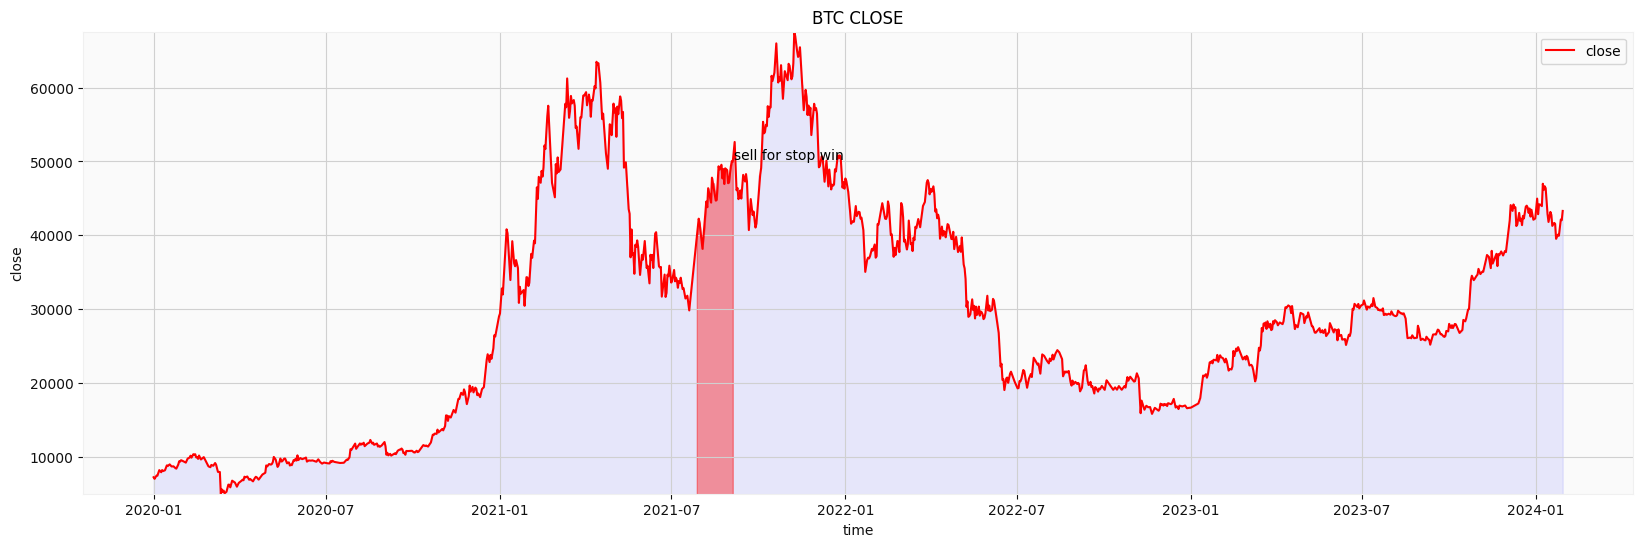

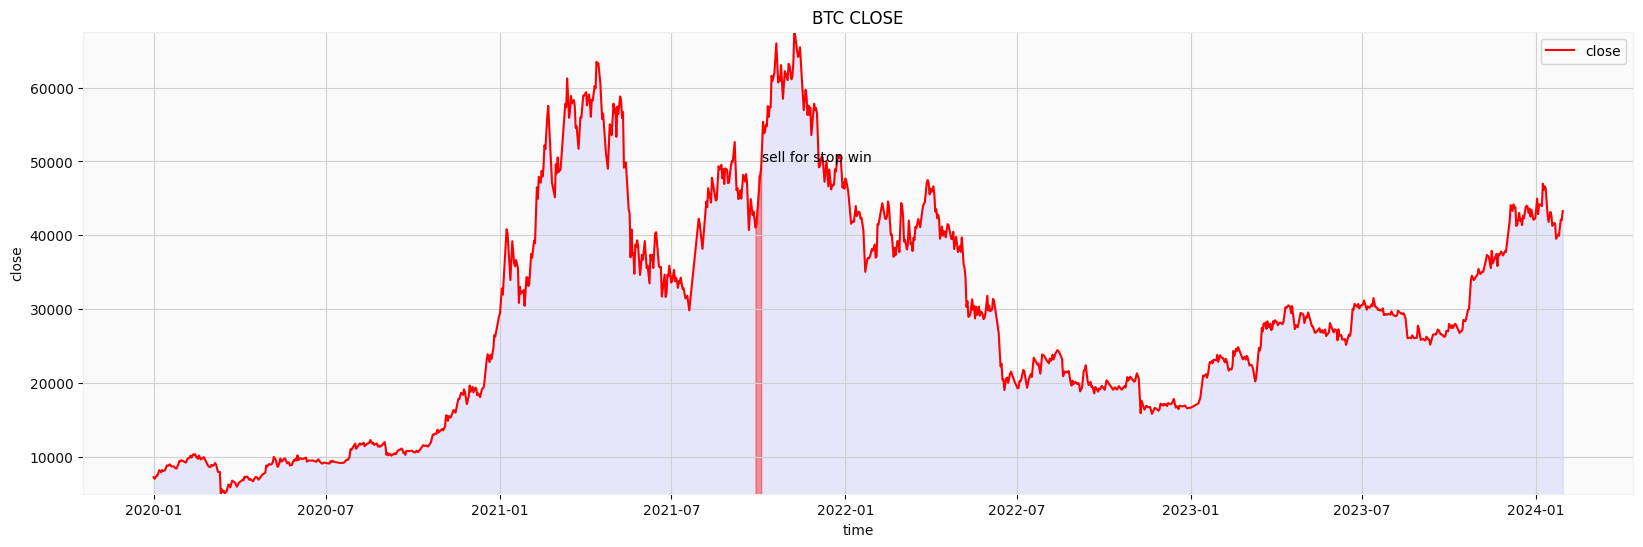

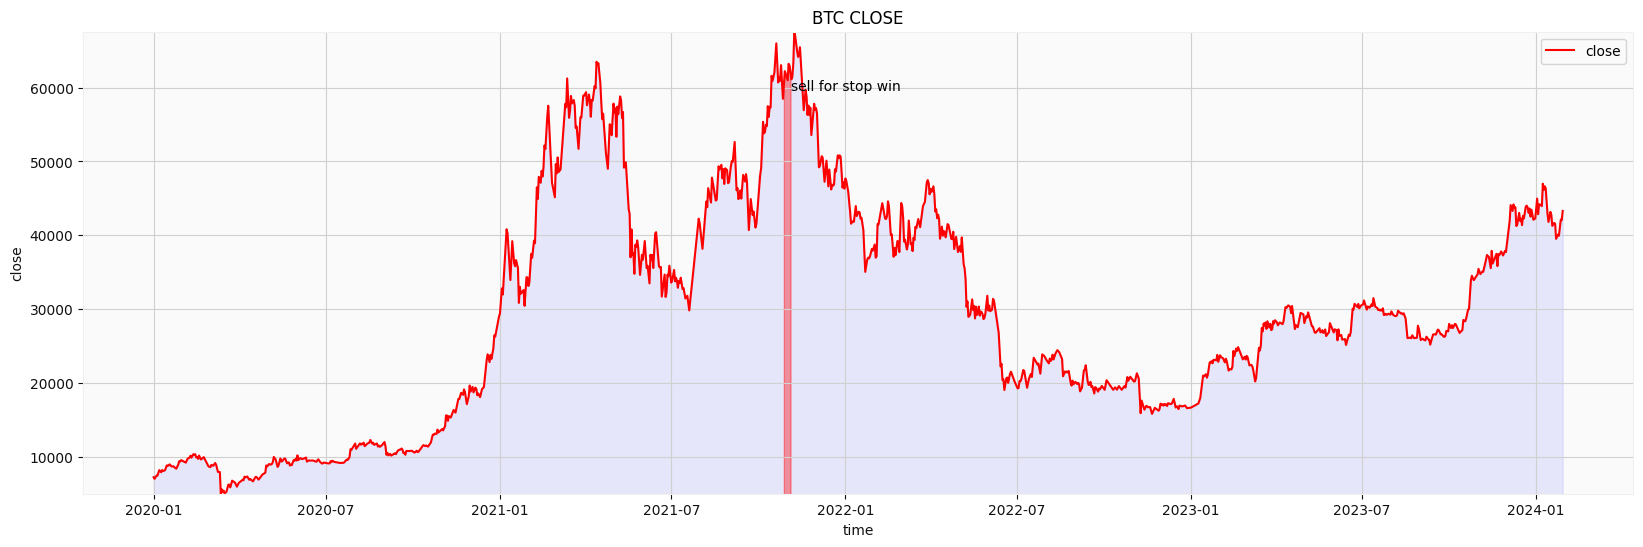

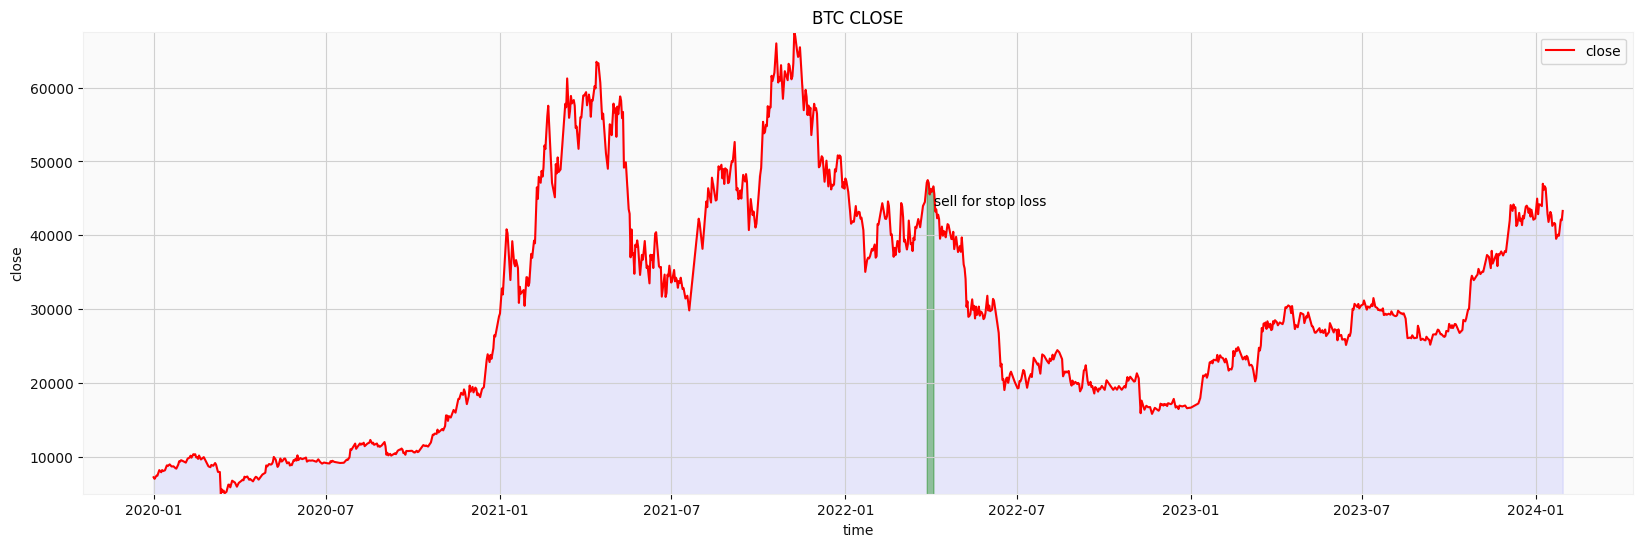

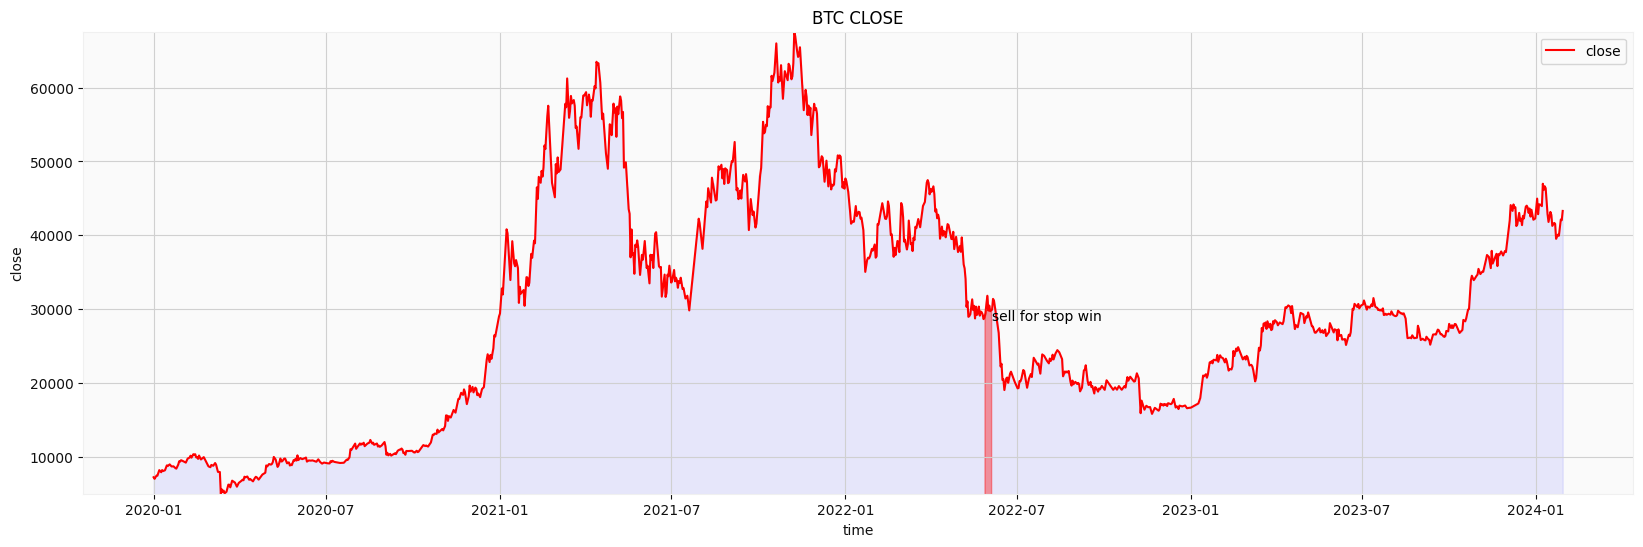

In [92]:
def plot_trade(df, buy_date, sell_date):
    # 找出2014-07-28对应时间序列中的index作为start
    start = df[df.index == buy_date].key.values[0]
    # 找出2014-09-05对应时间序列中的index作为end
    end = df[df.index == sell_date].key.values[0]
    # 使用5.1.1封装的绘制tsla收盘价格时间序列函数plot_demo
    # just_series＝True, 即只绘制一条曲线使用series数据
    plot_demo(df, just_series=True)
    # 将整个时间序列都填充一个底色blue，注意透明度alpha=0.08是为了
    # 之后标注其他区间透明度高于0.08就可以清楚显示
    plt.fill_between(df.index, 0, df['close'], color='blue', alpha=.08)
    # 标注股票持有周期绿色，使用start和end切片周期，透明度alpha=0.38 > 0.08
    if df['close'][end] < df['close'][start]:
        # 如果赔钱了显示绿色
        plt.fill_between(df.index[start:end], 0,
                         df['close'][start:end], color='green',
                         alpha=.38)
        is_win = False
    else:
        # 如果挣钱了显示红色
        plt.fill_between(df.index[start:end], 0,
                         df['close'][start:end], color='red',
                         alpha=.38)
        is_win = True

    # 设置y轴的显示范围，如果不设置ylim，将从0开始作为起点显示
    plt.ylim(np.min(df['close']) - 5,
             np.max(df['close']) + 5)
    # 使用loc='best'
    plt.legend(['close'], loc='best')
    # 将是否盈利结果返回
    return is_win


def plot_trade_with_annotate(df, buy_date, sell_date):
    """
    :param buy_date: 交易买入日期
    :param sell_date: 交易卖出日期
    :return:
    """
    # 标注交易区间buy_date到sell_date
    is_win = plot_trade(df, buy_date, sell_date)
    # 根据is_win来判断是否显示止盈还是止损卖出
    plt.annotate(
        'sell for stop win' if is_win else 'sell for stop loss',
        xy=(sell_date, df['close'].asof(sell_date)),
        arrowprops=dict(facecolor='yellow'),
        horizontalalignment='left', verticalalignment='top')

# 区间2014-07-28到2014-09-05
plot_trade_with_annotate(btc_df, datetime.datetime(2021,7,28), datetime.datetime(2021,9,5))
# 区间2015-01-28到2015-03-11
plot_trade_with_annotate(btc_df, datetime.datetime(2021,9,28), datetime.datetime(2021,10,5))
# 区间2015-04-10到2015-07-10
plot_trade_with_annotate(btc_df, datetime.datetime(2021,10,28), datetime.datetime(2021,11,5))
# 区间2015-10-2到2015-10-14
plot_trade_with_annotate(btc_df, datetime.datetime(2022,3,28), datetime.datetime(2022,4,5))
# 区间2016-02-10到2016-04-11
plot_trade_with_annotate(btc_df, datetime.datetime(2022,5,28), datetime.datetime(2022,6,5))

## 5.6 实例2:标准化两个股票的观察周期

In [93]:
eth_df = create_k_data('ETH')
# mean:打印均值，median：打印中位数
print(round(eth_df.close.mean(), 2), round(eth_df.close.median(), 2))
# 表5-3所示
eth_df.tail()

1729.05 1697.9


,key,open,high,low,close,adj close,volume,date_week,p_change
date,,,,,,,,,
2024-01-25,1485,2233.969971,2240.380859,2173.686523,2217.710205,2217.710205,9302247037,3,-0.712229
2024-01-26,1486,2217.441895,2280.383789,2196.140137,2267.199707,2267.199707,9975117607,4,2.207024
2024-01-27,1487,2267.319336,2282.544434,2252.385254,2267.885986,2267.885986,5144367230,5,0.030265
2024-01-28,1488,2268.192871,2306.898682,2242.683838,2257.208740,2257.208740,7296214994,6,-0.471913
2024-01-29,1489,2256.995361,2320.027344,2237.711670,2317.064209,2317.064209,8948195551,0,2.617198


Text(0, 0.5, 'close')

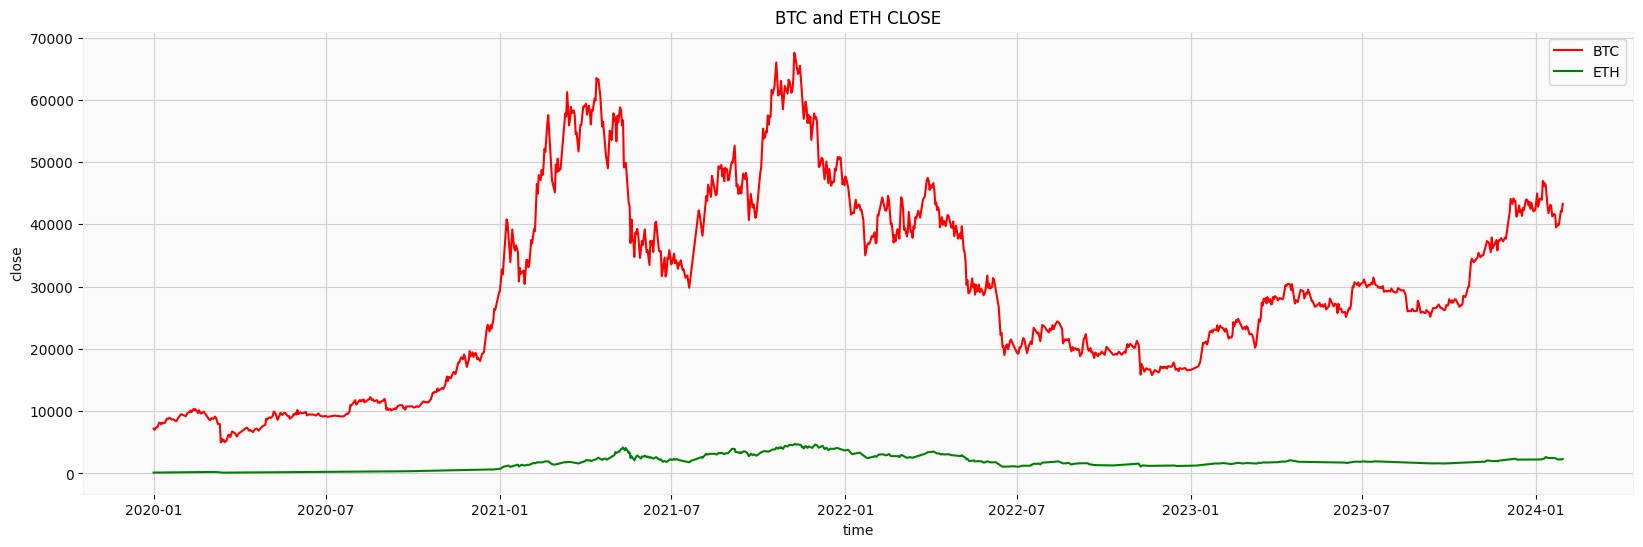

In [95]:
def plot_two_coins(btc_df, eth_df, axs=None, figsize=(20, 6)):
    # 如果有传递子画布，使用子画布，否则plt
    if axs is None:
        plt.figure(figsize=figsize)  # 在这里设置图形的大小
        drawer = plt
    else:
        drawer = axs  # 假设外部传入的axs已经有了figsize的设定
    # tsla red
    drawer.plot(btc_df, c='r')
    # google greeen
    drawer.plot(eth_df, c='g')
    # 显示网格
    drawer.grid(True)
    # 图例标注
    drawer.legend(['BTC', 'ETH'], loc='best')


plot_two_coins(btc_df.close, eth_df.close)
plt.title('BTC and ETH CLOSE')
# x轴时间
plt.xlabel('time')
# y轴收盘价格
plt.ylabel('close')

Text(0.5, 1.0, 'two_mean_list type_look=look_min')

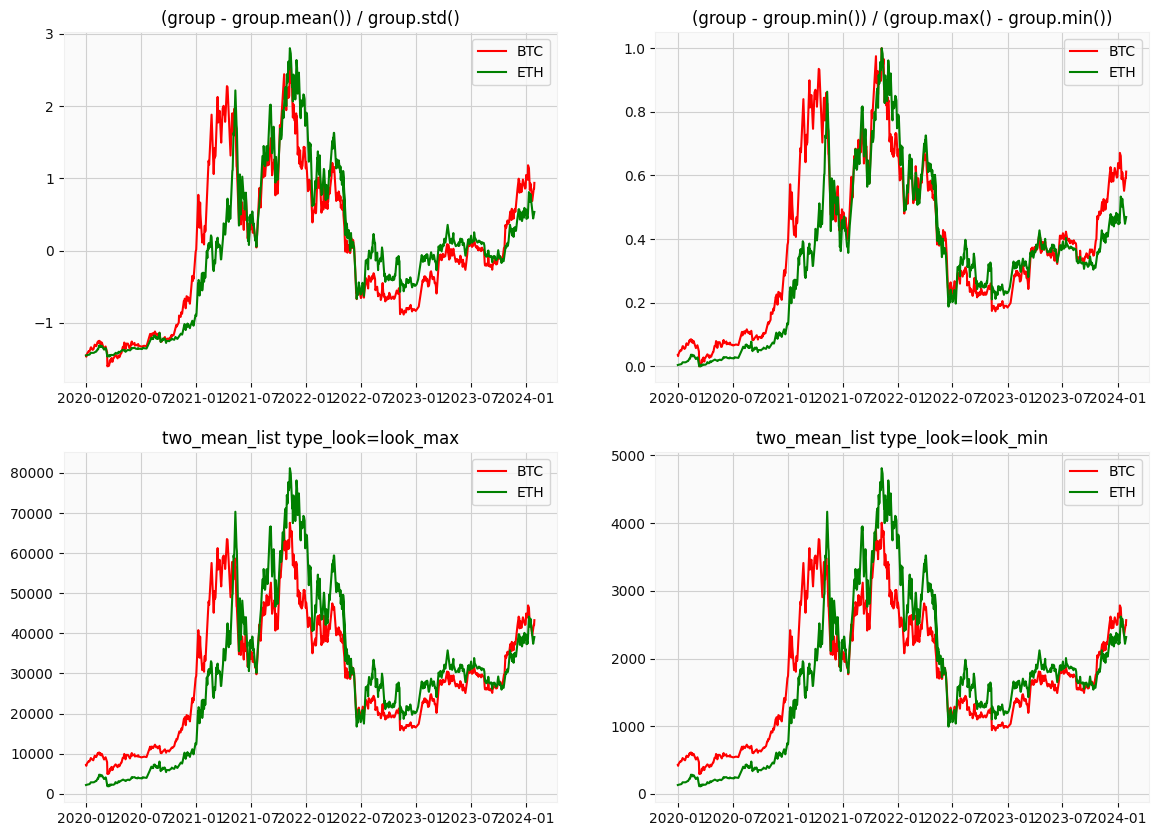

In [99]:
def two_mean_list(one, two, type_look='look_max'):
    """
    只针对俩个输入的均值归一化
    :param one:
    :param two:
    :param type_look:
    :return:
    """
    one_mean = one.mean()
    two_mean = two.mean()
    if type_look == 'look_max':
        """
            向较大的均值序列看齐
        """
        one, two = (one, one_mean / two_mean * two) \
            if one_mean > two_mean else (
            one * two_mean / one_mean, two)
    elif type_look == 'look_min':
        """
            向较小的均值序列看齐
        """
        one, two = (one * two_mean / one_mean, two) \
            if one_mean > two_mean else (
            one, two * one_mean / two_mean)
    return one, two

def regular_std(group):
    # z-score规范化也称零-均值规范化
    return (group - group.mean()) / group.std()

def regular_mm(group):
    # 最小-最大规范化
    return (group - group.min()) / (group.max() - group.min())

# 2行2列，4个画布
_, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# 第一个regular_std, 如图5-16左上所示
drawer = axs[0][0]
plot_two_coins(regular_std(btc_df.close), regular_std(eth_df.close),
               drawer)
drawer.set_title('(group - group.mean()) / group.std()')

# 第二个regular_mm，如图5-16右上所示
drawer = axs[0][1]
plot_two_coins(regular_mm(btc_df.close), regular_mm(eth_df.close),
               drawer)
drawer.set_title(
    '(group - group.min()) / (group.max() - group.min())')

# 第三个向较大的序列看齐，如图5-16左上所示
drawer = axs[1][0]
one, two = two_mean_list(btc_df.close, eth_df.close,
                         type_look='look_max')
plot_two_coins(one, two, drawer)
drawer.set_title('two_mean_list type_look=look_max')

# 第四个向较小的序列看齐，如图5-16右下所示
drawer = axs[1][1]
one, two = two_mean_list(btc_df.close, eth_df.close,
                         type_look='look_min')
plot_two_coins(one, two, drawer)
drawer.set_title('two_mean_list type_look=look_min')

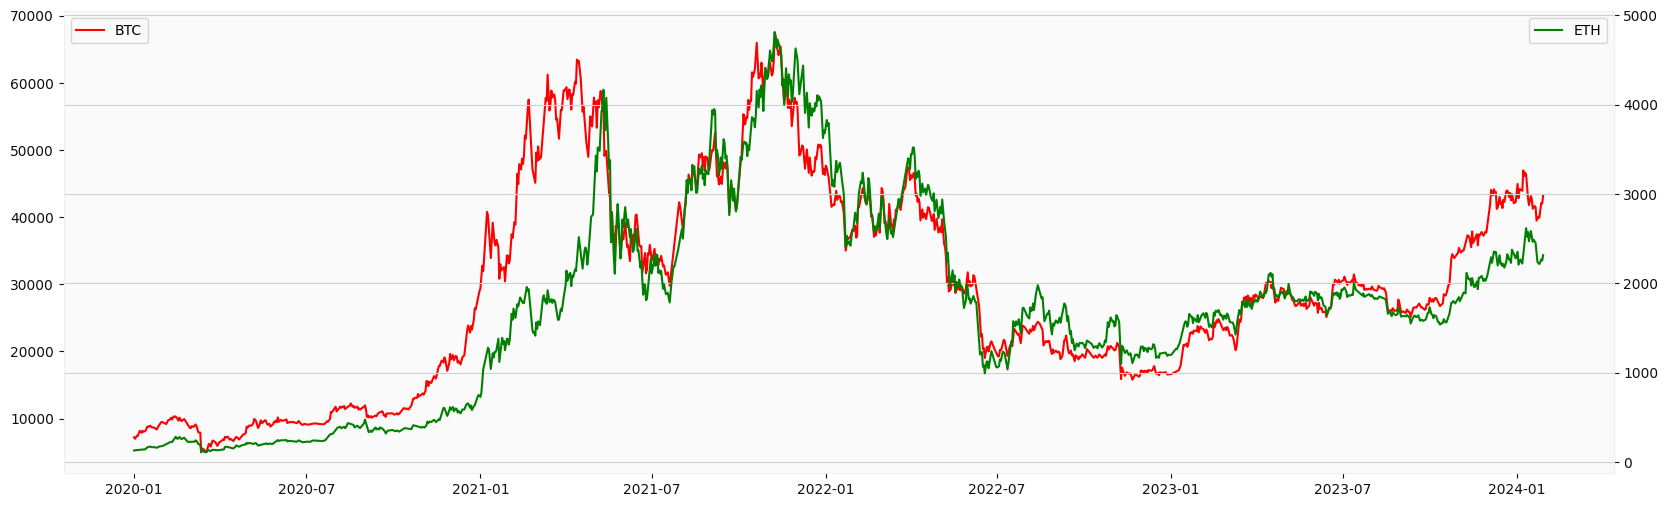

In [101]:
_, ax1 = plt.subplots(figsize=(20,6))
ax1.plot(btc_df.close, c='r', label='BTC')
# 第一个ax的标注
ax1.legend(loc=2)
ax1.grid(False)
# 反向y轴 twinx
ax2 = ax1.twinx()
ax2.plot(eth_df.close, c='g', label='ETH')
# 第二个ax的标志
ax2.legend(loc=1)

## 5.7 综合实例3:黄金分割线

In [102]:
# 收盘价格序列中的最大值
cs_max = btc_df.close.max()
# 收盘价格序列中的最小值
cs_min = btc_df.close.min()

sp382 = (cs_max - cs_min) * 0.382 + cs_min
sp618 = (cs_max - cs_min) * 0.618 + cs_min
print('视觉上的382: ' + str(round(sp382, 2)))
print('视觉上的618: ' + str(round(sp618, 2)))

视觉上的382: 28882.48
视觉上的618: 43655.14


In [104]:
from scipy import stats

sp382_stats = stats.scoreatpercentile(btc_df.close, 38.2)
sp618_stats = stats.scoreatpercentile(btc_df.close, 61.8)

print('统计上的382: ' + str(round(sp382_stats, 2)))
print('统计上的618: ' + str(round(sp618_stats, 2)))

统计上的382: 22804.74
统计上的618: 32790.17


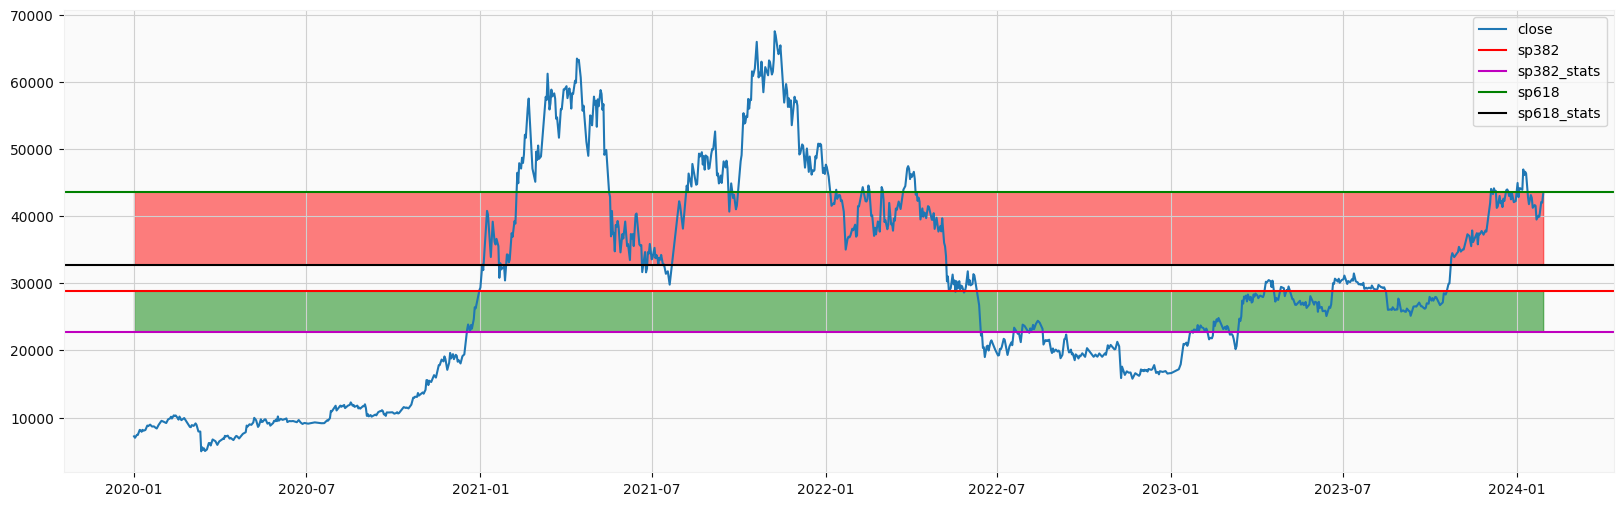

In [109]:
from collections import namedtuple


def plot_golden(df):
    # 从视觉618和统计618中筛选更大的值
    above618 = np.maximum(sp618, sp618_stats)
    # 从视觉618和统计618中筛选更小的值
    below618 = np.minimum(sp618, sp618_stats)
    # 从视觉382和统计382中筛选更大的值
    above382 = np.maximum(sp382, sp382_stats)
    # 从视觉382和统计382中筛选更小的值
    below382 = np.minimum(sp382, sp382_stats)
    
    # 绘制收盘价
    plt.figure(figsize=(20,6))  # 在这里设置图形的大小
    plt.plot(df.close)
    # 水平线视觉382
    plt.axhline(sp382, c='r')
    # 水平线统计382
    plt.axhline(sp382_stats, c='m')
    # 水平线视觉618
    plt.axhline(sp618, c='g')
    # 水平线统计618
    plt.axhline(sp618_stats, c='k')

    # 填充618 red
    plt.fill_between(df.index, above618, below618,
                     alpha=0.5, color="r")
    # 填充382 green
    plt.fill_between(df.index, above382, below382,
                     alpha=0.5, color="g")

    # 最后使用namedtuple包装上，方便获取
    return namedtuple('golden', ['above618', 'below618', 'above382',
                                 'below382'])(
        above618, below618, above382, below382)

golden = plot_golden(btc_df)
# 根据绘制顺序标注名称
plt.legend(['close', 'sp382', 'sp382_stats', 'sp618', 'sp618_stats'],
           loc='best')

## 5.8 技术指标的可视化
### 5.8.1 MACD指标的可视化 

In [ ]:
from abupy import nd
nd.macd.plot_macd_from_klpd(tsla_df)

### ATR指标的可视化

In [ ]:
from abupy import nd
nd.atr.plot_atr_from_klpd(tsla_df)